Training

Mounted at /content/drive


Training Epochs:   4%|▍         | 20/500 [05:47<1:00:52,  7.61s/it]

Epoch 020, Loss: 0.017551


Training Epochs:   8%|▊         | 40/500 [08:20<58:01,  7.57s/it]

Epoch 040, Loss: 0.010850


Training Epochs:  12%|█▏        | 60/500 [10:52<55:53,  7.62s/it]

Epoch 060, Loss: 0.009751


Training Epochs:  16%|█▌        | 80/500 [13:28<52:31,  7.50s/it]

Epoch 080, Loss: 0.007626


Training Epochs:  20%|██        | 100/500 [16:40<50:59,  7.65s/it]

Epoch 100, Loss: 0.007786


Training Epochs:  24%|██▍       | 120/500 [19:15<49:45,  7.86s/it]

Epoch 120, Loss: 0.007321


Training Epochs:  28%|██▊       | 140/500 [21:52<47:21,  7.89s/it]

Epoch 140, Loss: 0.002585


Training Epochs:  32%|███▏      | 160/500 [24:27<43:43,  7.72s/it]

Epoch 160, Loss: 0.002563


Training Epochs:  36%|███▌      | 180/500 [27:48<41:24,  7.77s/it]

Epoch 180, Loss: 0.002537


Training Epochs:  40%|████      | 200/500 [30:23<38:44,  7.75s/it]

Epoch 200, Loss: 0.004531


Training Epochs:  44%|████▍     | 220/500 [33:01<37:45,  8.09s/it]

Epoch 220, Loss: 0.001542


Training Epochs:  48%|████▊     | 240/500 [35:38<33:39,  7.77s/it]

Epoch 240, Loss: 0.003439


Training Epochs:  52%|█████▏    | 260/500 [38:35<49:17, 12.32s/it]

Epoch 260, Loss: 0.001301


Training Epochs:  56%|█████▌    | 280/500 [40:51<25:08,  6.85s/it]

Epoch 280, Loss: 0.001483


Training Epochs:  60%|██████    | 300/500 [43:09<23:15,  6.98s/it]

Epoch 300, Loss: 0.001807


Training Epochs:  64%|██████▍   | 320/500 [45:26<20:37,  6.87s/it]

Epoch 320, Loss: 0.000822


Training Epochs:  68%|██████▊   | 340/500 [47:43<18:01,  6.76s/it]

Epoch 340, Loss: 0.002174


Training Epochs:  72%|███████▏  | 360/500 [50:00<15:56,  6.83s/it]

Epoch 360, Loss: 0.003291


Training Epochs:  76%|███████▌  | 380/500 [52:16<13:38,  6.82s/it]

Epoch 380, Loss: 0.001002


Training Epochs:  80%|████████  | 400/500 [54:33<11:28,  6.88s/it]

Epoch 400, Loss: 0.000779


Training Epochs:  84%|████████▍ | 420/500 [56:50<09:04,  6.81s/it]

Epoch 420, Loss: 0.004694


Training Epochs:  88%|████████▊ | 440/500 [59:11<06:52,  6.87s/it]

Epoch 440, Loss: 0.000993


Training Epochs:  92%|█████████▏| 460/500 [1:01:35<04:30,  6.75s/it]

Epoch 460, Loss: 0.000688


Training Epochs:  96%|█████████▌| 480/500 [1:03:49<02:17,  6.86s/it]

Epoch 480, Loss: 0.000761


Training Epochs: 100%|██████████| 500/500 [1:06:39<00:00,  8.00s/it]

Epoch 500, Loss: 0.000487


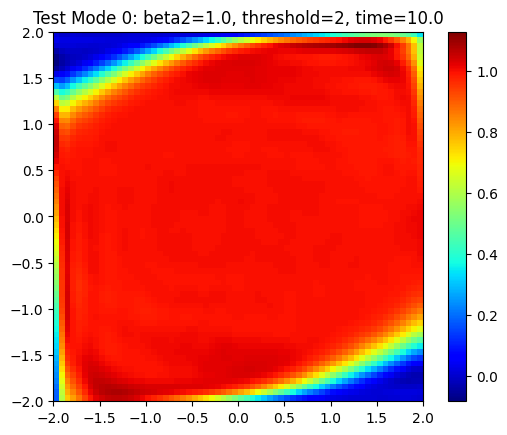

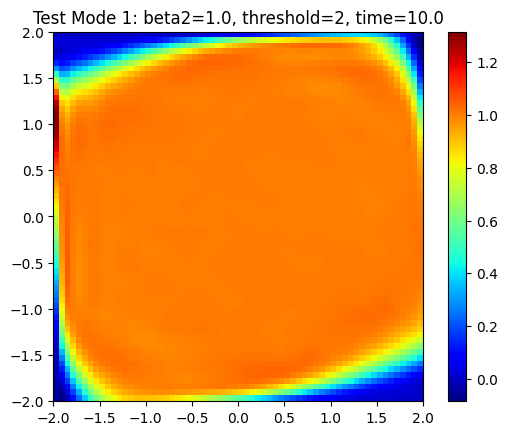

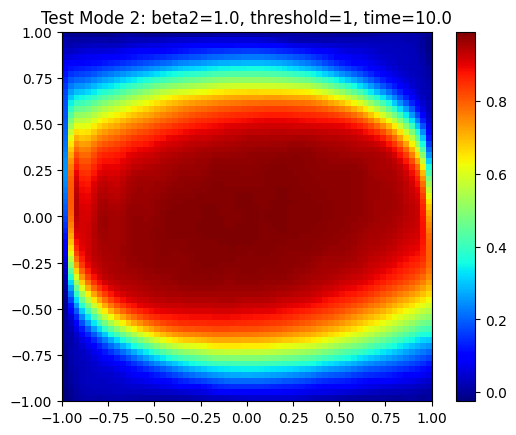

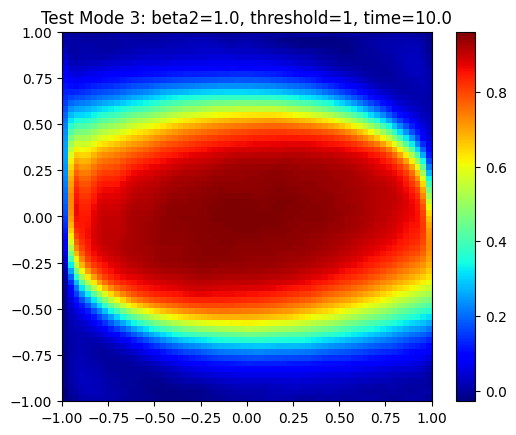

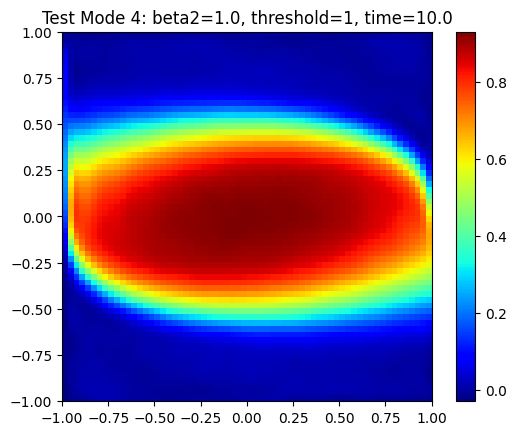

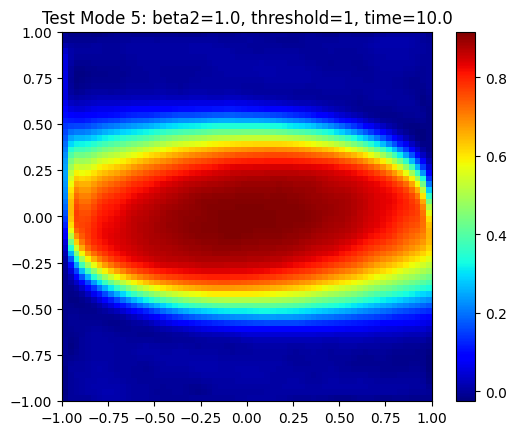

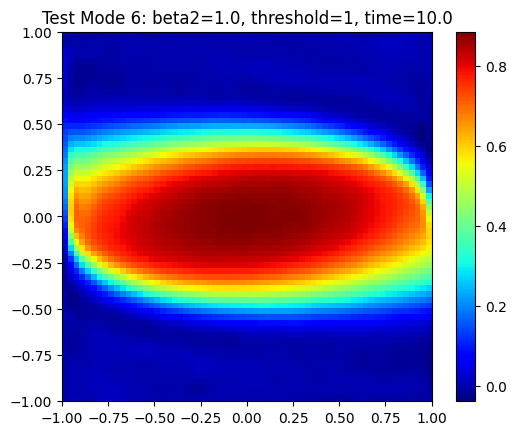

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, glob, re
import numpy as np
import scipy.io
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# ---------------------------
# 1. Data Loading and Preprocessing (with Sampled Time Index as Input)
# ---------------------------
# Fixed eigenvalues for the 7 modes (for consistency)
lambda_vals = [0, 0.7091, 2.0567, 3.1134, 4.6842, 5.3759, 6.0607]

grid_size = 64  # resolution for the neural operator

def resample_data(solution, grid_size=64):
    factor = 256 // grid_size
    return solution[::factor, ::factor]

def get_normalized_grid(threshold, grid_size=64):
    # Original grid: [-threshold, threshold] with 256 points, normalized to [-1,1]
    x = np.linspace(-threshold, threshold, 256)
    y = np.linspace(-threshold, threshold, 256)
    x_norm = x / threshold
    y_norm = y / threshold
    factor = 256 // grid_size
    x_norm_resampled = x_norm[::factor]
    y_norm_resampled = y_norm[::factor]
    grid_x, grid_y = np.meshgrid(x_norm_resampled, y_norm_resampled, indexing='ij')
    return grid_x, grid_y

class PDEDataset(Dataset):
    """
    Loads each MATLAB file (one sample per mode per config), parses parameters from the filename,
    randomly samples a time snapshot (with weighted probability favoring early times), and
    constructs an input field of shape (grid_size, grid_size, 6) and an output field (grid_size, grid_size, 1).

    The 6 input channels are:
      1. x-coordinate (normalized)
      2. y-coordinate (normalized)
      3. beta2 value (constant field)
      4. threshold (constant field)
      5. lambda value (constant field)
      6. time value computed as sampled time index/10
    """
    def __init__(self, data_dir, grid_size=64):
        self.file_list = glob.glob(os.path.join(data_dir,
            'SafeProb_FK_GeneralGraph_solData_config*_mode*_beta2=*_thres=*.mat'))
        self.grid_size = grid_size

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        mat_data = scipy.io.loadmat(file_path)
        basename = os.path.basename(file_path)
        # Example filename: SafeProb_FK_GeneralGraph_solData_config10_mode0_beta2=1.23_thres=1.50.mat
        pattern = r'config(\d+)_mode(\d+)_beta2=([\d\.]+)_thres=([\d\.]+)'
        match = re.search(pattern, basename)
        if match:
            config_num = int(match.group(1))
            mode_num = int(match.group(2))
            beta2 = float(match.group(3))
            threshold = float(match.group(4).rstrip('.'))
        else:
            raise ValueError("Filename parsing failed for " + basename)

        var_name = f"data_config{config_num}_mode{mode_num}"
        data_array = mat_data[var_name]  # shape: (num_times, 256, 256)
        num_times = data_array.shape[0]

        # Define weights for time steps:
        # - Very high weight (5.0) for time indices < 10
        # - Moderate weight (2.0) for indices between 10 and 49
        # - Default weight (1.0) for the rest
        weights = np.ones(num_times)
        for i in range(num_times):
            if i < 10:
                weights[i] = 5.0
            elif i < 50:
                weights[i] = 2.0
            else:
                weights[i] = 1.0
        weights = weights / np.sum(weights)

        # Sample one time index with weighted probability.
        sampled_idx = np.random.choice(num_times, p=weights)
        snapshot = data_array[sampled_idx]
        # Instead of using the time array from file, use the sampled index divided by 10.
        sampled_time = sampled_idx / 10.0

        solution_resampled = resample_data(snapshot, self.grid_size)
        grid_x, grid_y = get_normalized_grid(threshold, self.grid_size)

        lam = lambda_vals[mode_num]
        beta2_field = beta2 * np.ones_like(grid_x)
        threshold_field = threshold * np.ones_like(grid_x)
        lam_field = lam * np.ones_like(grid_x)
        time_field = sampled_time * np.ones_like(grid_x)  # time based on sampled index

        # Stack to form input: [x_norm, y_norm, beta2, threshold, lambda, time]
        input_field = np.stack([grid_x, grid_y, beta2_field, threshold_field, lam_field, time_field], axis=-1)
        output_field = solution_resampled[..., None]

        input_tensor = torch.tensor(input_field, dtype=torch.float32)
        output_tensor = torch.tensor(output_field, dtype=torch.float32)
        return input_tensor, output_tensor

data_dir = '/content/drive/MyDrive/Multi Agent PDE/Data_Beta2_Thres/'
dataset = PDEDataset(data_dir, grid_size=grid_size)

# Split dataset (80/20 split)
n_total = len(dataset)
n_train = int(0.8 * n_total)
n_val = n_total - n_train
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# ---------------------------
# 2. B-spline Basis Functions
# ---------------------------
def BsFun(i, d, t, Ln):
    if d == 0:
        return 1.0 if Ln[i - 1] <= t < Ln[i] else 0.0
    else:
        a = 0 if (Ln[d+i-1]-Ln[i-1])==0 else (t - Ln[i-1])/(Ln[d+i-1]-Ln[i-1])
        b = 0 if (Ln[d+i]-Ln[i])==0 else (Ln[d+i]-t)/(Ln[d+i]-Ln[i])
        return a * BsFun(i, d-1, t, Ln) + b * BsFun(i+1, d-1, t, Ln)

def BsKnots(n_cp, d, Ns):
    n_knots = n_cp + d + 1
    Ln = np.zeros(n_knots)
    for i in range(d+1, n_knots-d):
        Ln[i] = i - d
    Ln[n_knots-d:] = n_cp - d
    tk = np.linspace(0, Ln[-1], Ns)
    Bit = np.zeros((Ns, n_cp))
    for j in range(n_cp):
        for i in range(Ns):
            Bit[i, j] = BsFun(j+1, d, tk[i], Ln)
    Bit[-1, n_cp-1] = 1
    return tk, Ln, Bit

# Choose number of control points and B-spline order.
n_cp1 = 25   # for first spatial dimension
n_cp2 = 25   # for second spatial dimension
d = 3        # B-spline order

# Compute B-spline basis matrices for both dimensions (each of shape: (grid_size, n_cp))
_, _, Bit_1_np = BsKnots(n_cp1, d, grid_size)
_, _, Bit_2_np = BsKnots(n_cp2, d, grid_size)
Bit_1 = torch.tensor(Bit_1_np, dtype=torch.float32)  # shape: (grid_size, n_cp1)
Bit_2 = torch.tensor(Bit_2_np, dtype=torch.float32)  # shape: (grid_size, n_cp2)

# ---------------------------
# 3. Define the B-spline Neural Operator Model
# ---------------------------
class NeuralOperatorBSplineNet(nn.Module):
    def __init__(self, in_channels, modes1, modes2, width, n_cp1, n_cp2, n_layers=4):
        """
        This network lifts the input (of shape [grid_size, grid_size, in_channels])
        and applies alternating spectral and pointwise convolutions.
        Instead of directly outputting the solution, it predicts a grid of control points,
        of shape (n_cp1, n_cp2), which will be used to reconstruct the solution via B-spline bases.
        """
        super(NeuralOperatorBSplineNet, self).__init__()
        self.n_cp1 = n_cp1
        self.n_cp2 = n_cp2
        self.fc0 = nn.Linear(in_channels, width)
        self.conv_layers = nn.ModuleList()
        for _ in range(n_layers):
            self.conv_layers.append(SpectralConv2d(width, width, modes1, modes2))
            self.conv_layers.append(nn.Conv2d(width, width, 1))
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, n_cp1 * n_cp2)

    def forward(self, x):
        # x: (batch, grid_size, grid_size, in_channels)
        batchsize, nx, ny, _ = x.shape
        x = self.fc0(x)  # shape: (batch, nx, ny, width)
        x = x.permute(0, 3, 1, 2)  # shape: (batch, width, nx, ny)
        for i in range(0, len(self.conv_layers), 2):
            x1 = self.conv_layers[i](x)
            x2 = self.conv_layers[i+1](x)
            x = F.gelu(x1 + x2)
        x = x.mean(dim=[2, 3])  # global average pooling, shape: (batch, width)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = x.view(batchsize, self.n_cp1, self.n_cp2)
        return x

# Reuse the spectral conv class from FNO.
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2
        self.scale = 1/(in_channels * out_channels)
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))
    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy, ioxy -> boxy", input, weights)
    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1,
                              device=x.device, dtype=torch.cfloat)
        m1 = min(self.modes1, x_ft.size(-2))
        m2 = min(self.modes2, x_ft.size(-1))
        out_ft[:, :, :m1, :m2] = self.compl_mul2d(x_ft[:, :, :m1, :m2], self.weights[:, :, :m1, :m2])
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

# Update in_channels from 5 to 6 (to include the time channel)
in_channels = 6  # [x_norm, y_norm, beta2, threshold, lambda, time]
modes1, modes2 = 12, 12
width = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bspline = NeuralOperatorBSplineNet(in_channels, modes1, modes2, width, n_cp1, n_cp2, n_layers=4).to(device)

optimizer = optim.Adam(model_bspline.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# ---------------------------
# 4. Training Loop
# ---------------------------
epochs = 500
model_bspline.train()
for epoch in tqdm(range(epochs), desc="Training Epochs"):
    total_loss = 0.0
    model_bspline.train()
    for x, y in train_loader:
        x = x.to(device)  # shape: (B, grid_size, grid_size, 6)
        y = y.to(device)  # shape: (B, grid_size, grid_size, 1)
        optimizer.zero_grad()
        U_pred = model_bspline(x)  # shape: (B, n_cp1, n_cp2)
        # Reconstruct solution: pred_field = Bit_1 @ U @ Bit_2^T, shape: (B, grid_size, grid_size)
        pred_field = torch.matmul(torch.matmul(Bit_1.to(device), U_pred), Bit_2.to(device).T)
        pred_field = pred_field.unsqueeze(-1)  # shape: (B, grid_size, grid_size, 1)
        loss = loss_fn(pred_field, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    total_loss /= len(train_loader.dataset)
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1:03d}, Loss: {total_loss:.6f}")

# ---------------------------
# 5. Testing on New Input Configuration (with Time Input)
# ---------------------------
# For testing, you may set time to a desired value.
# Here we choose a test time value (for example, 10.0) for the network input.
model_bspline.eval()
test_beta2 = 1.0
test_thresholds = [2, 2, 1, 1, 1, 1, 1]
test_time = 10.0  # chosen test time

test_results = {}

for mode_num in range(7):
    test_threshold = test_thresholds[mode_num]
    test_lambda = lambda_vals[mode_num]
    grid_x, grid_y = get_normalized_grid(test_threshold, grid_size)
    beta2_field = test_beta2 * np.ones_like(grid_x)
    threshold_field = test_threshold * np.ones_like(grid_x)
    lambda_field = test_lambda * np.ones_like(grid_x)
    time_field = test_time * np.ones_like(grid_x)  # fixed test time field
    input_field = np.stack([grid_x, grid_y, beta2_field, threshold_field, lambda_field, time_field], axis=-1)
    input_tensor = torch.tensor(input_field, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        U_pred = model_bspline(input_tensor)  # shape: (1, n_cp1, n_cp2)
        pred_field = torch.matmul(torch.matmul(Bit_1.to(device), U_pred[0]), Bit_2.to(device).T)
        pred_field = pred_field.cpu().numpy()  # shape: (grid_size, grid_size)
    test_results[mode_num] = pred_field
    plt.figure()
    plt.imshow(pred_field, cmap='jet', extent=[-test_threshold, test_threshold, -test_threshold, test_threshold])
    plt.title(f"Test Mode {mode_num}: beta2={test_beta2}, threshold={test_threshold}, time={test_time}")
    plt.colorbar()
    plt.show()


In [ ]:
# # ---------------------------
# # Save the trained model
# # ---------------------------
# model_save_path = '/content/drive/MyDrive/Multi Agent PDE/Data_Beta2_Thres/model_bspline_with_time.pth'
# torch.save(model_bspline.state_dict(), model_save_path)
# print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/Multi Agent PDE/Data_Beta2_Thres/model_bspline_with_time.pth


Load trained network

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, glob, re
import numpy as np
import scipy.io
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# ---------------------------
# 1. Data Loading and Preprocessing (with Sampled Time Index as Input)
# ---------------------------
# Fixed eigenvalues for the 7 modes (for consistency)
lambda_vals = [0, 0.7091, 2.0567, 3.1134, 4.6842, 5.3759, 6.0607]

grid_size = 64  # resolution for the neural operator

def resample_data(solution, grid_size=64):
    factor = 256 // grid_size
    return solution[::factor, ::factor]

def get_normalized_grid(threshold, grid_size=64):
    # Original grid: [-threshold, threshold] with 256 points, normalized to [-1,1]
    x = np.linspace(-threshold, threshold, 256)
    y = np.linspace(-threshold, threshold, 256)
    x_norm = x / threshold
    y_norm = y / threshold
    factor = 256 // grid_size
    x_norm_resampled = x_norm[::factor]
    y_norm_resampled = y_norm[::factor]
    grid_x, grid_y = np.meshgrid(x_norm_resampled, y_norm_resampled, indexing='ij')
    return grid_x, grid_y

class PDEDataset(Dataset):
    """
    Loads each MATLAB file (one sample per mode per config), parses parameters from the filename,
    randomly samples a time snapshot (with weighted probability favoring early times), and
    constructs an input field of shape (grid_size, grid_size, 6) and an output field (grid_size, grid_size, 1).

    The 6 input channels are:
      1. x-coordinate (normalized)
      2. y-coordinate (normalized)
      3. beta2 value (constant field)
      4. threshold (constant field)
      5. lambda value (constant field)
      6. time value computed as sampled time index/10
    """
    def __init__(self, data_dir, grid_size=64):
        self.file_list = glob.glob(os.path.join(data_dir,
            'SafeProb_FK_GeneralGraph_solData_config*_mode*_beta2=*_thres=*.mat'))
        self.grid_size = grid_size

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        mat_data = scipy.io.loadmat(file_path)
        basename = os.path.basename(file_path)
        # Example filename: SafeProb_FK_GeneralGraph_solData_config10_mode0_beta2=1.23_thres=1.50.mat
        pattern = r'config(\d+)_mode(\d+)_beta2=([\d\.]+)_thres=([\d\.]+)'
        match = re.search(pattern, basename)
        if match:
            config_num = int(match.group(1))
            mode_num = int(match.group(2))
            beta2 = float(match.group(3))
            threshold = float(match.group(4).rstrip('.'))
        else:
            raise ValueError("Filename parsing failed for " + basename)

        var_name = f"data_config{config_num}_mode{mode_num}"
        data_array = mat_data[var_name]  # shape: (num_times, 256, 256)
        num_times = data_array.shape[0]

        # Define weights for time steps:
        # - Very high weight (5.0) for time indices < 10
        # - Moderate weight (2.0) for indices between 10 and 49
        # - Default weight (1.0) for the rest
        weights = np.ones(num_times)
        for i in range(num_times):
            if i < 10:
                weights[i] = 5.0
            elif i < 50:
                weights[i] = 2.0
            else:
                weights[i] = 1.0
        weights = weights / np.sum(weights)

        # Sample one time index with weighted probability.
        sampled_idx = np.random.choice(num_times, p=weights)
        snapshot = data_array[sampled_idx]
        # Instead of using the time array from file, use the sampled index divided by 10.
        sampled_time = sampled_idx / 10.0

        solution_resampled = resample_data(snapshot, self.grid_size)
        grid_x, grid_y = get_normalized_grid(threshold, self.grid_size)

        lam = lambda_vals[mode_num]
        beta2_field = beta2 * np.ones_like(grid_x)
        threshold_field = threshold * np.ones_like(grid_x)
        lam_field = lam * np.ones_like(grid_x)
        time_field = sampled_time * np.ones_like(grid_x)  # time based on sampled index

        # Stack to form input: [x_norm, y_norm, beta2, threshold, lambda, time]
        input_field = np.stack([grid_x, grid_y, beta2_field, threshold_field, lam_field, time_field], axis=-1)
        output_field = solution_resampled[..., None]

        input_tensor = torch.tensor(input_field, dtype=torch.float32)
        output_tensor = torch.tensor(output_field, dtype=torch.float32)
        return input_tensor, output_tensor

data_dir = '/content/drive/MyDrive/Multi Agent PDE/Data_Beta2_Thres/'
dataset = PDEDataset(data_dir, grid_size=grid_size)


# ---------------------------
# 2. B-spline Basis Functions
# ---------------------------
def BsFun(i, d, t, Ln):
    if d == 0:
        return 1.0 if Ln[i - 1] <= t < Ln[i] else 0.0
    else:
        a = 0 if (Ln[d+i-1]-Ln[i-1])==0 else (t - Ln[i-1])/(Ln[d+i-1]-Ln[i-1])
        b = 0 if (Ln[d+i]-Ln[i])==0 else (Ln[d+i]-t)/(Ln[d+i]-Ln[i])
        return a * BsFun(i, d-1, t, Ln) + b * BsFun(i+1, d-1, t, Ln)

def BsKnots(n_cp, d, Ns):
    n_knots = n_cp + d + 1
    Ln = np.zeros(n_knots)
    for i in range(d+1, n_knots-d):
        Ln[i] = i - d
    Ln[n_knots-d:] = n_cp - d
    tk = np.linspace(0, Ln[-1], Ns)
    Bit = np.zeros((Ns, n_cp))
    for j in range(n_cp):
        for i in range(Ns):
            Bit[i, j] = BsFun(j+1, d, tk[i], Ln)
    Bit[-1, n_cp-1] = 1
    return tk, Ln, Bit

# Choose number of control points and B-spline order.
n_cp1 = 25   # for first spatial dimension
n_cp2 = 25   # for second spatial dimension
d = 3        # B-spline order

# Compute B-spline basis matrices for both dimensions (each of shape: (grid_size, n_cp))
_, _, Bit_1_np = BsKnots(n_cp1, d, grid_size)
_, _, Bit_2_np = BsKnots(n_cp2, d, grid_size)
Bit_1 = torch.tensor(Bit_1_np, dtype=torch.float32)  # shape: (grid_size, n_cp1)
Bit_2 = torch.tensor(Bit_2_np, dtype=torch.float32)  # shape: (grid_size, n_cp2)

# ---------------------------
# 3. Define the B-spline Neural Operator Model
# ---------------------------
class NeuralOperatorBSplineNet(nn.Module):
    def __init__(self, in_channels, modes1, modes2, width, n_cp1, n_cp2, n_layers=4):
        """
        This network lifts the input (of shape [grid_size, grid_size, in_channels])
        and applies alternating spectral and pointwise convolutions.
        Instead of directly outputting the solution, it predicts a grid of control points,
        of shape (n_cp1, n_cp2), which will be used to reconstruct the solution via B-spline bases.
        """
        super(NeuralOperatorBSplineNet, self).__init__()
        self.n_cp1 = n_cp1
        self.n_cp2 = n_cp2
        self.fc0 = nn.Linear(in_channels, width)
        self.conv_layers = nn.ModuleList()
        for _ in range(n_layers):
            self.conv_layers.append(SpectralConv2d(width, width, modes1, modes2))
            self.conv_layers.append(nn.Conv2d(width, width, 1))
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, n_cp1 * n_cp2)

    def forward(self, x):
        # x: (batch, grid_size, grid_size, in_channels)
        batchsize, nx, ny, _ = x.shape
        x = self.fc0(x)  # shape: (batch, nx, ny, width)
        x = x.permute(0, 3, 1, 2)  # shape: (batch, width, nx, ny)
        for i in range(0, len(self.conv_layers), 2):
            x1 = self.conv_layers[i](x)
            x2 = self.conv_layers[i+1](x)
            x = F.gelu(x1 + x2)
        x = x.mean(dim=[2, 3])  # global average pooling, shape: (batch, width)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = x.view(batchsize, self.n_cp1, self.n_cp2)
        return x

# Reuse the spectral conv class from FNO.
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2
        self.scale = 1/(in_channels * out_channels)
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))
    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy, ioxy -> boxy", input, weights)
    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1,
                              device=x.device, dtype=torch.cfloat)
        m1 = min(self.modes1, x_ft.size(-2))
        m2 = min(self.modes2, x_ft.size(-1))
        out_ft[:, :, :m1, :m2] = self.compl_mul2d(x_ft[:, :, :m1, :m2], self.weights[:, :, :m1, :m2])
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

# Update in_channels from 5 to 6 (to include the time channel)
in_channels = 6  # [x_norm, y_norm, beta2, threshold, lambda, time]
modes1, modes2 = 12, 12
width = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bspline = NeuralOperatorBSplineNet(in_channels, modes1, modes2, width, n_cp1, n_cp2, n_layers=4).to(device)

optimizer = optim.Adam(model_bspline.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

model_bspline.load_state_dict(torch.load('/content/drive/MyDrive/Multi Agent PDE/Data_Beta2_Thres/model_bspline_with_time.pth'))

Mounted at /content/drive


<All keys matched successfully>

Testing

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mode 0: Time index 3 (t = 0.3), MSE = 0.000736


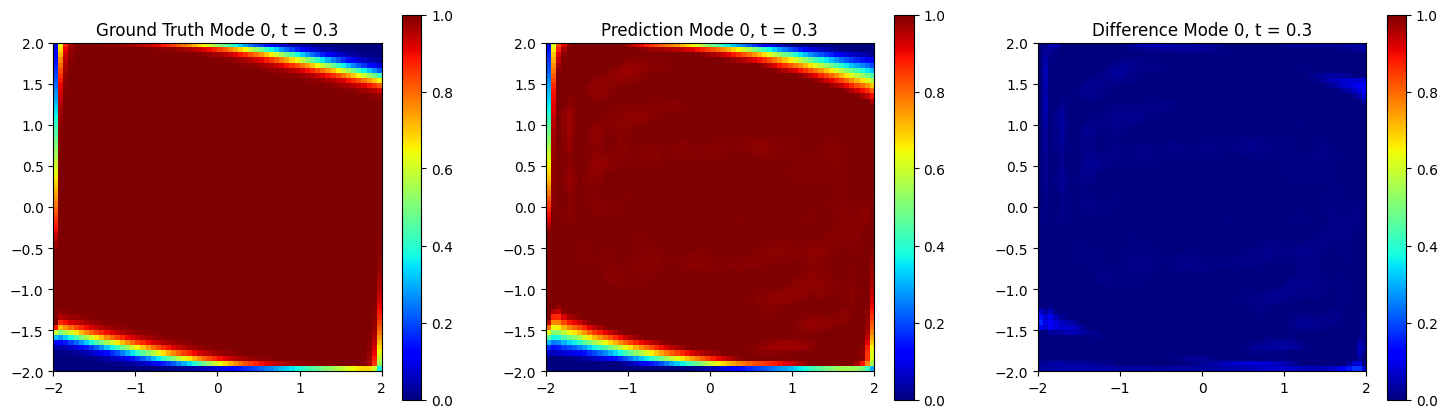

Mode 1: Time index 3 (t = 0.3), MSE = 0.000758


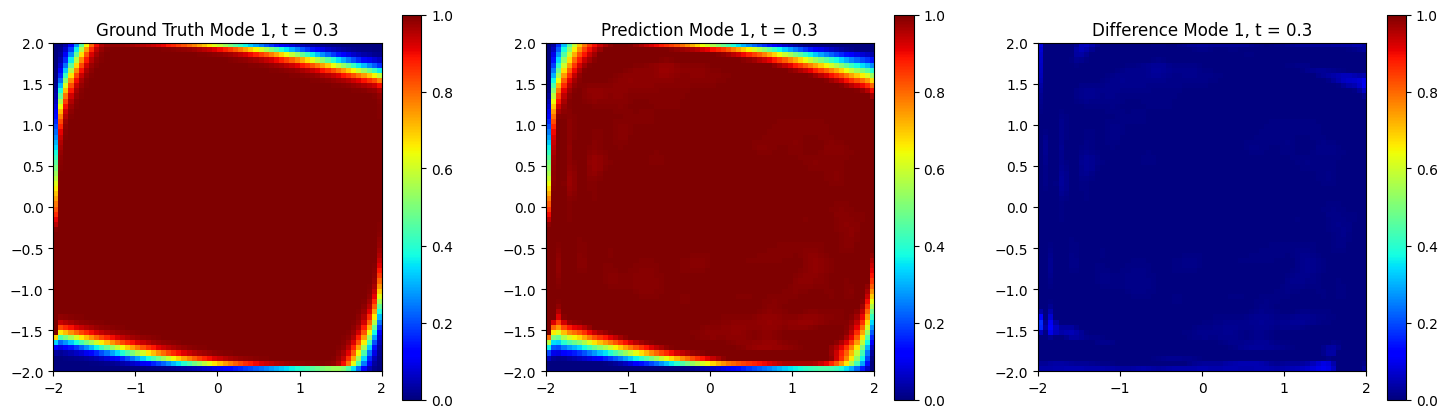

Mode 2: Time index 3 (t = 0.3), MSE = 0.000644


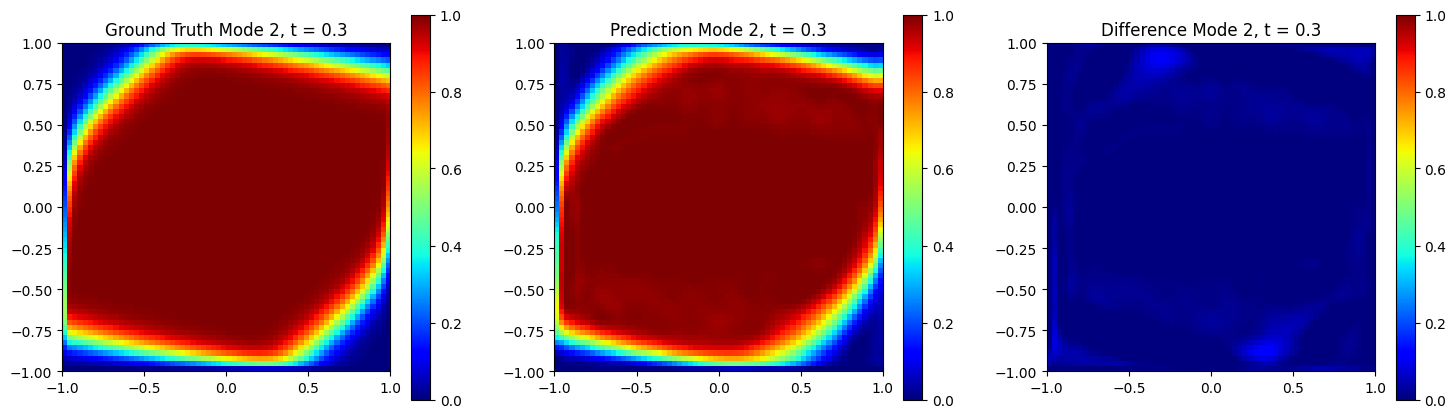

Mode 3: Time index 3 (t = 0.3), MSE = 0.000758


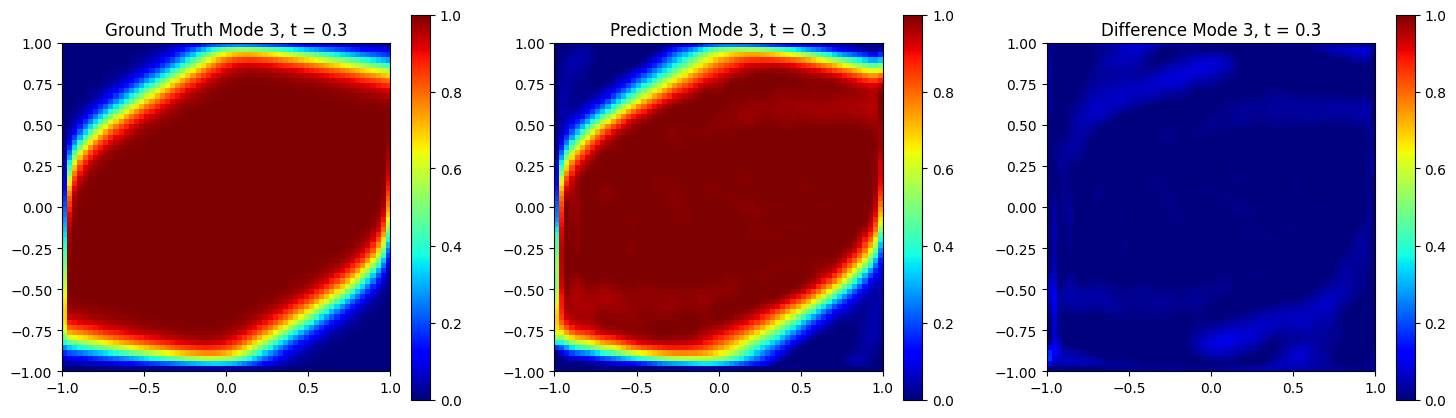

Mode 4: Time index 3 (t = 0.3), MSE = 0.001495


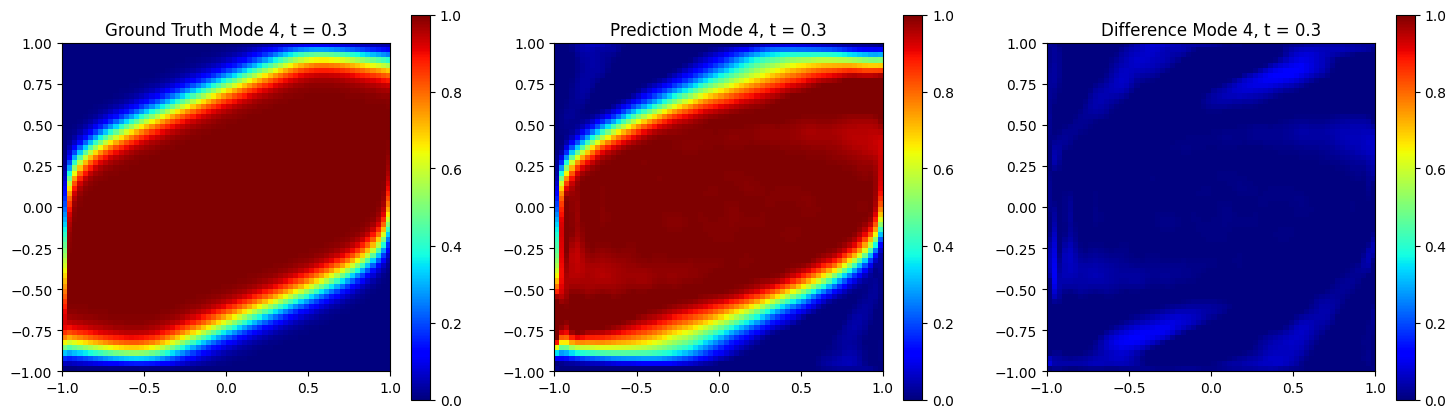

Mode 5: Time index 3 (t = 0.3), MSE = 0.001675


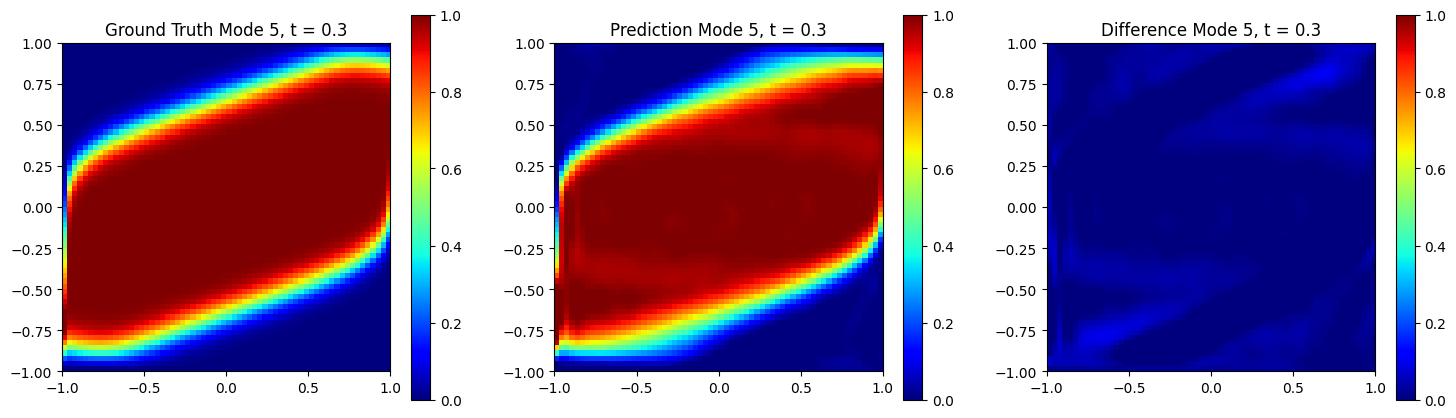

Mode 6: Time index 3 (t = 0.3), MSE = 0.002752


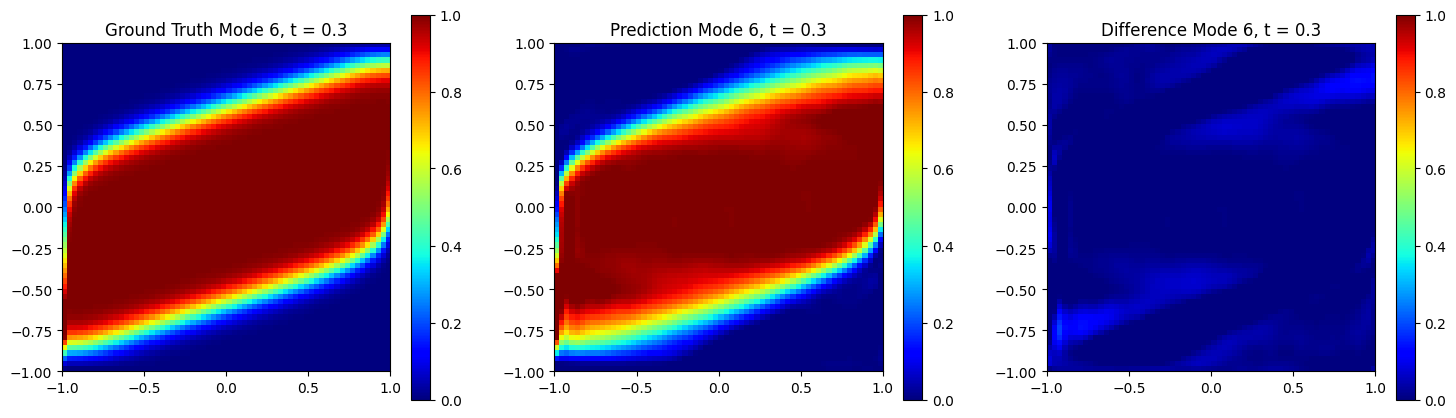

In [ ]:
# ---------------------------
# Ground Truth Comparison using Network Inference
# ---------------------------
import os
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import torch
from google.colab import drive
drive.mount('/content/drive')

# Use the same grid_size and lambda values as before
grid_size = 64
lambda_vals = [0, 0.7091, 2.0567, 3.1134, 4.6842, 5.3759, 6.0607]

# Downsampling function (from 256x256 to grid_size x grid_size)
def resample_data(solution, grid_size=64):
    factor = 256 // grid_size
    return solution[::factor, ::factor]

# Normalized grid function
def get_normalized_grid(threshold, grid_size=64):
    x = np.linspace(-threshold, threshold, 256)
    y = np.linspace(-threshold, threshold, 256)
    x_norm = x / threshold
    y_norm = y / threshold
    factor = 256 // grid_size
    x_norm_resampled = x_norm[::factor]
    y_norm_resampled = y_norm[::factor]
    grid_x, grid_y = np.meshgrid(x_norm_resampled, y_norm_resampled, indexing='ij')
    return grid_x, grid_y

# Settings for comparison
N = 7  # number of modes
gt_base = '/content/drive/MyDrive/Multi Agent PDE/Data_Beta2_Thres/'
# Ground truth files are expected to be named like:
# "SafeProb_FK_GeneralGraph_solData_(lambda_{mode},sigma=0.2).mat"
# and contain a variable "data_lambda_{mode}" of shape (101, 256, 256).

# Test configuration: choose beta2 and threshold per mode (these should match the GT simulation)
test_beta2 = 1.0
test_thresholds = [2, 2, 1, 1, 1, 1, 1]  # example thresholds for each mode

# Choose a time index for comparison and compute the corresponding time input
time_idx = 3                # (for example, 30 out of 101 time steps)
t_input = time_idx / 10.0    # the network was trained with time = index/10

# Make sure the network is in evaluation mode.
model_bspline.eval()

# Loop over each mode for comparison
for mode in range(N):
    varname = f"data_lambda_{mode}"
    gt_filename = os.path.join(gt_base, f"SafeProb_FK_GeneralGraph_solData_(lambda_{mode},sigma=0.2).mat")
    gt_struct = scipy.io.loadmat(gt_filename)

    if varname not in gt_struct:
        raise ValueError(f"Variable {varname} not found in file {gt_filename}")

    # Ground truth full data: shape (101, 256, 256)
    gt_full = gt_struct[varname]
    # Extract the slice corresponding to the chosen time index and downsample it
    gt_slice_full = gt_full[time_idx, :, :]  # shape: (256,256)
    gt_slice = resample_data(gt_slice_full, grid_size)  # shape: (64,64)

    # Set parameters for the current mode
    test_threshold = test_thresholds[mode]
    test_lambda = lambda_vals[mode]

    # Construct the normalized grid and the constant parameter fields
    grid_x, grid_y = get_normalized_grid(test_threshold, grid_size)
    beta2_field = test_beta2 * np.ones_like(grid_x)
    threshold_field = test_threshold * np.ones_like(grid_x)
    lambda_field = test_lambda * np.ones_like(grid_x)
    time_field = t_input * np.ones_like(grid_x)  # use the chosen time

    # Stack the channels to form the input field (shape: 64 x 64 x 6)
    input_field = np.stack([grid_x, grid_y, beta2_field, threshold_field, lambda_field, time_field], axis=-1)
    input_tensor = torch.tensor(input_field, dtype=torch.float32).unsqueeze(0).to(device)

    # Run the network and reconstruct the prediction via the B-spline basis matrices
    with torch.no_grad():
        U_pred = model_bspline(input_tensor)  # shape: (1, n_cp1, n_cp2)
        pred_field = torch.matmul(torch.matmul(Bit_1.to(device), U_pred[0]), Bit_2.to(device).T)
        pred_field = pred_field.cpu().numpy()  # shape: (64,64)

    # Compute Mean Squared Error (MSE) between prediction and ground truth
    mse_val = np.mean((gt_slice - pred_field)**2)
    print(f"Mode {mode}: Time index {time_idx} (t = {t_input}), MSE = {mse_val:.6f}")

    # Compute the difference slice for visualization
    diff_slice = gt_slice - pred_field

    # Plot ground truth, prediction, and difference side-by-side
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    im0 = axs[0].imshow(gt_slice, cmap='jet', origin='lower', vmin=0, vmax=1,
                        extent=[-test_threshold, test_threshold, -test_threshold, test_threshold])
    axs[0].set_title(f'Ground Truth Mode {mode}, t = {t_input}')
    plt.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(pred_field, cmap='jet', origin='lower', vmin=0, vmax=1,
                        extent=[-test_threshold, test_threshold, -test_threshold, test_threshold])
    axs[1].set_title(f'Prediction Mode {mode}, t = {t_input}')
    plt.colorbar(im1, ax=axs[1])

    im2 = axs[2].imshow(diff_slice, cmap='jet', origin='lower', vmin=0, vmax=1,
                        extent=[-test_threshold, test_threshold, -test_threshold, test_threshold])
    axs[2].set_title(f'Difference Mode {mode}, t = {t_input}')
    plt.colorbar(im2, ax=axs[2])

    plt.show()


save data to .mat file

In [ ]:
import os
import numpy as np
import scipy.io
import torch
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# Parameters and Settings
# ---------------------------
grid_size = 256          # desired spatial resolution (256x256)
time_steps = 101         # number of time steps
lambda_vals = [0, 0.7091, 2.0567, 3.1134, 4.6842, 5.3759, 6.0607]

# Testing configuration: β₂ and thresholds per mode
test_beta2 = 1.0
test_thresholds = [2, 2, 1, 1, 1, 1, 1]
N = 7  # number of modes

# Directory and filename to save all variables in one .mat file
output_mat_file = '/content/drive/MyDrive/Multi Agent PDE/Data_Beta2_Thres/SafeProb_FK_GeneralGraph_solData_matlab_with_time.mat'

# ---------------------------
# Helper Functions
# ---------------------------
def get_normalized_grid(threshold, grid_size=256):
    """
    Creates a normalized spatial grid over [-threshold, threshold] with grid_size points.
    """
    x = np.linspace(-threshold, threshold, grid_size)
    y = np.linspace(-threshold, threshold, grid_size)
    x_norm = x / threshold
    y_norm = y / threshold
    grid_x, grid_y = np.meshgrid(x_norm, y_norm, indexing='ij')
    return grid_x, grid_y

def BsFun(i, d, t, Ln):
    if d == 0:
        return 1.0 if Ln[i - 1] <= t < Ln[i] else 0.0
    else:
        a = 0 if (Ln[d+i-1]-Ln[i-1])==0 else (t - Ln[i-1])/(Ln[d+i-1]-Ln[i-1])
        b = 0 if (Ln[d+i]-Ln[i])==0 else (Ln[d+i]-t)/(Ln[d+i]-Ln[i])
        return a * BsFun(i, d-1, t, Ln) + b * BsFun(i+1, d-1, t, Ln)

def BsKnots(n_cp, d, Ns):
    n_knots = n_cp + d + 1
    Ln = np.zeros(n_knots)
    for i in range(d+1, n_knots-d):
        Ln[i] = i - d
    Ln[n_knots-d:] = n_cp - d
    tk = np.linspace(0, Ln[-1], Ns)
    Bit = np.zeros((Ns, n_cp))
    for j in range(n_cp):
        for i in range(Ns):
            Bit[i, j] = BsFun(j+1, d, tk[i], Ln)
    Bit[-1, n_cp-1] = 1
    return tk, Ln, Bit

# ---------------------------
# Compute B-spline Bases at Full Resolution (256x256)
# ---------------------------
# These parameters should match those used during training.
n_cp1 = 25
n_cp2 = 25
d = 3
_, _, Bit_1_np = BsKnots(n_cp1, d, grid_size)  # shape: (256, n_cp1)
_, _, Bit_2_np = BsKnots(n_cp2, d, grid_size)  # shape: (256, n_cp2)
Bit_1 = torch.tensor(Bit_1_np, dtype=torch.float32)
Bit_2 = torch.tensor(Bit_2_np, dtype=torch.float32)

# ---------------------------
# Make sure the model is in evaluation mode.
# (Assumes model_bspline is already defined, loaded, and on device.)
# ---------------------------
model_bspline.eval()

# ---------------------------
# Generate Predictions for All Modes and Time Steps
# ---------------------------
# Dictionary to collect predictions for each mode.
all_predictions = {}

for mode in range(N):
    test_threshold = test_thresholds[mode]
    test_lambda = lambda_vals[mode]

    # Create the normalized spatial grid (256x256) for the current threshold.
    grid_x, grid_y = get_normalized_grid(test_threshold, grid_size)

    # Constant parameter fields.
    beta2_field = test_beta2 * np.ones_like(grid_x)
    threshold_field = test_threshold * np.ones_like(grid_x)
    lambda_field = test_lambda * np.ones_like(grid_x)

    # Preallocate array for predictions: shape (101, 256, 256)
    predictions = np.zeros((time_steps, grid_size, grid_size), dtype=np.float64)

    for t_idx in range(time_steps):
        # Compute time input (assuming the network was trained with time = index/10)
        t_input = t_idx / 10.0
        time_field = t_input * np.ones_like(grid_x)

        # Stack channels: [x_norm, y_norm, beta2, threshold, lambda, time]
        input_field = np.stack([grid_x, grid_y, beta2_field, threshold_field, lambda_field, time_field], axis=-1)
        input_tensor = torch.tensor(input_field, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            # Forward pass: predict control points (assumed output shape: (1, n_cp1, n_cp2))
            U_pred = model_bspline(input_tensor)
            # Reconstruct the full-field prediction using the B-spline bases.
            pred_field = torch.matmul(torch.matmul(Bit_1.to(device), U_pred[0]), Bit_2.to(device).T)
            pred_field = pred_field.cpu().numpy()  # shape: (256, 256)

        predictions[t_idx, :, :] = pred_field

    # Store predictions for this mode with the variable name data_lambda_mode
    all_predictions[f"data_lambda_{mode}"] = predictions
    print(f"Mode {mode}: Prediction shape = {predictions.shape}")

# ---------------------------
# Save all predictions into one .mat file
# ---------------------------
scipy.io.savemat(output_mat_file, all_predictions)
print(f"All predictions saved in {output_mat_file}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mode 0: Prediction shape = (101, 256, 256)
Mode 1: Prediction shape = (101, 256, 256)
Mode 2: Prediction shape = (101, 256, 256)
Mode 3: Prediction shape = (101, 256, 256)
Mode 4: Prediction shape = (101, 256, 256)
Mode 5: Prediction shape = (101, 256, 256)
Mode 6: Prediction shape = (101, 256, 256)
All predictions saved in /content/drive/MyDrive/Multi Agent PDE/Data_Beta2_Thres/SafeProb_FK_GeneralGraph_solData_matlab_with_time.mat


Timing the inference

In [ ]:
import os
import numpy as np
import scipy.io
import torch
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# Parameters and Settings
# ---------------------------
grid_size = 256          # desired spatial resolution (256x256)
time_steps = 101         # number of time steps
lambda_vals = [0, 0.7091, 2.0567, 3.1134, 4.6842, 5.3759, 6.0607]

# Testing configuration: β₂ and thresholds per mode
test_beta2 = 1.0
test_thresholds = [2, 2, 1, 1, 1, 1, 1]
N = 7  # number of modes

# Directory and filename to save all variables in one .mat file
output_mat_file = '/content/drive/MyDrive/Multi Agent PDE/Data_Beta2_Thres/SafeProb_FK_GeneralGraph_solData_matlab_with_time.mat'

# ---------------------------
# Helper Functions
# ---------------------------
def get_normalized_grid(threshold, grid_size=256):
    """
    Creates a normalized spatial grid over [-threshold, threshold] with grid_size points.
    """
    x = np.linspace(-threshold, threshold, grid_size)
    y = np.linspace(-threshold, threshold, grid_size)
    x_norm = x / threshold
    y_norm = y / threshold
    grid_x, grid_y = np.meshgrid(x_norm, y_norm, indexing='ij')
    return grid_x, grid_y

def BsFun(i, d, t, Ln):
    if d == 0:
        return 1.0 if Ln[i - 1] <= t < Ln[i] else 0.0
    else:
        a = 0 if (Ln[d+i-1]-Ln[i-1])==0 else (t - Ln[i-1])/(Ln[d+i-1]-Ln[i-1])
        b = 0 if (Ln[d+i]-Ln[i])==0 else (Ln[d+i]-t)/(Ln[d+i]-Ln[i])
        return a * BsFun(i, d-1, t, Ln) + b * BsFun(i+1, d-1, t, Ln)

def BsKnots(n_cp, d, Ns):
    n_knots = n_cp + d + 1
    Ln = np.zeros(n_knots)
    for i in range(d+1, n_knots-d):
        Ln[i] = i - d
    Ln[n_knots-d:] = n_cp - d
    tk = np.linspace(0, Ln[-1], Ns)
    Bit = np.zeros((Ns, n_cp))
    for j in range(n_cp):
        for i in range(Ns):
            Bit[i, j] = BsFun(j+1, d, tk[i], Ln)
    Bit[-1, n_cp-1] = 1
    return tk, Ln, Bit

import time
start_time = time.time()

# ---------------------------
# Compute B-spline Bases at Full Resolution (256x256)
# ---------------------------
n_cp1 = 25
n_cp2 = 25
d = 3
_, _, Bit_1_np = BsKnots(n_cp1, d, grid_size)  # shape: (256, n_cp1)
_, _, Bit_2_np = BsKnots(n_cp2, d, grid_size)  # shape: (256, n_cp2)
Bit_1 = torch.tensor(Bit_1_np, dtype=torch.float32)
Bit_2 = torch.tensor(Bit_2_np, dtype=torch.float32)

# ---------------------------
# Make sure the model is in evaluation mode.
# (Assumes model_bspline is already defined, loaded, and on device.)
# ---------------------------
model_bspline.eval()

# ---------------------------
# Generate Predictions for All Modes and Time Steps
# ---------------------------
all_predictions = {}

for mode in range(N):
    test_threshold = test_thresholds[mode]
    test_lambda = lambda_vals[mode]

    grid_x, grid_y = get_normalized_grid(test_threshold, grid_size)

    beta2_field = test_beta2 * np.ones_like(grid_x)
    threshold_field = test_threshold * np.ones_like(grid_x)
    lambda_field = test_lambda * np.ones_like(grid_x)

    predictions = np.zeros((time_steps, grid_size, grid_size), dtype=np.float64)

    for t_idx in range(time_steps):
        t_input = t_idx / 10.0
        time_field = t_input * np.ones_like(grid_x)

        input_field = np.stack([grid_x, grid_y, beta2_field, threshold_field, lambda_field, time_field], axis=-1)
        input_tensor = torch.tensor(input_field, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            U_pred = model_bspline(input_tensor)
            pred_field = torch.matmul(torch.matmul(Bit_1.to(device), U_pred[0]), Bit_2.to(device).T)
            pred_field = pred_field.cpu().numpy()

        predictions[t_idx, :, :] = pred_field

    all_predictions[f"data_lambda_{mode}"] = predictions
    print(f"Mode {mode}: Prediction shape = {predictions.shape}")


# -------------------------------------
# Timing: Calculate and print elapsed time
# -------------------------------------
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Script completed in {elapsed_time:.2f} seconds")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mode 0: Prediction shape = (101, 256, 256)
Mode 1: Prediction shape = (101, 256, 256)
Mode 2: Prediction shape = (101, 256, 256)
Mode 3: Prediction shape = (101, 256, 256)
Mode 4: Prediction shape = (101, 256, 256)
Mode 5: Prediction shape = (101, 256, 256)
Mode 6: Prediction shape = (101, 256, 256)
Script completed in 56.47 seconds
